# Mean squared error

Best hyperparameters: {'svr__gamma': 0.01, 'svr__epsilon': 1, 'svr__C': 1000, 'select__k': 3}
Mean squared error: -0.06907193765763278
course_ML: False, p-value: 0.4232931608582372
course_retrieval: False, p-value: 0.47108119845709884
course_statistics: True, p-value: 0.005896936252828015
course_databases: False, p-value: 0.41943153221865626
gender: False, p-value: 0.4958642029820335
ChatGPT: False, p-value: 0.10259798368659791
age: False, p-value: 0.7650863729065188
students_in_room: False, p-value: 0.09706370476471446
prev_answer_stand: True, p-value: 0.010789003246906658
sports_per_week: True, p-value: 2.9824427791548697e-05
Test set mean squared error: 1224.5906465067344
Test set mean absolute error: 30.489644737244586
Test set R-squared score: -0.14589555338572024
95% confidence interval for test set predictions: [38.43981648677175, 56.60936384109711]


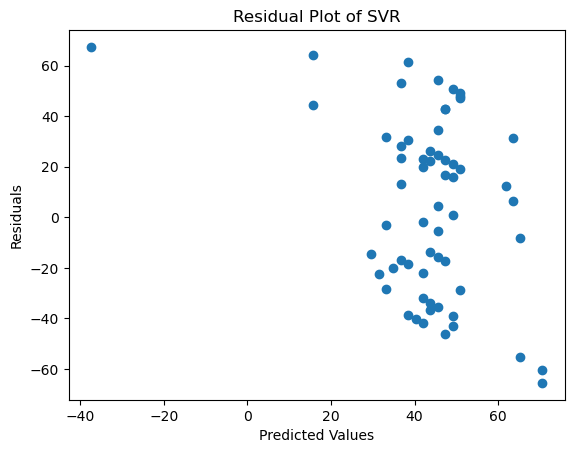

Shapiro-Wilk test for normality of residuals:
Statistic: 0.967003583908081
p-value: 0.09868869930505753
The residuals are likely normally distributed.


In [77]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

# Load the dataset
data = pd.read_csv('new_data_fill_missing_linear&mode.csv')

# data = data.dropna()
# Print the number of missing values in each column
# print(data.isnull().sum())

# Replace missing values with the median value for that column
# data = data.fillna(data.median())

# Separate target variable and feature variables
target = data['stress_level']
data = data.drop(['stress_level','programme',"Tijdstempel",'random_number','good_day_(1)',
                  'good_day_(2)','birthday','bed_time'], axis=1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Scale the features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the hyperparameters to be tuned
param_distributions = {
        'svr__C': [0.1, 1, 10, 100, 1000],
            'svr__epsilon': [0.0001, 0.0005,  0.001, 0.005,  0.01, 0.05, 1, 5, 10],
            'svr__gamma': [0.0001, 0.0005,  0.001, 0.005,  0.01, 0.05, 1, 5, 10],
     'select__k': [2, 3, 4]  # select the best 2, 3, or 4 features
}

# Create a pipeline to select the best features and train the SVR model
pipeline = Pipeline([
    ('select', SelectKBest(f_regression)),
    ('svr', SVR())
])

# Perform a randomized search to find the best hyperparameters
randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_distributions, n_iter=100, cv=5, random_state=42)
randomized_search.fit(X_train, y_train)

# Print the best hyperparameters and their corresponding MSE score
print("Best hyperparameters:", randomized_search.best_params_)
print("Mean squared error:", -randomized_search.best_score_)

# Print the selected features and their p-values
selected_features = randomized_search.best_estimator_.named_steps['select'].get_support()
p_values = randomized_search.best_estimator_.named_steps['select'].pvalues_
feature_names = data.columns
for i in range(len(feature_names)):
    print(f"{feature_names[i]}: {selected_features[i]}, p-value: {p_values[i]}")

# Evaluate the performance on the test set using the best hyperparameters
y_pred = randomized_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Test set mean squared error:", mse)
print("Test set mean absolute error:", mae)
print("Test set R-squared score:", r2)

# Calculate the confidence interval for the test set
n = len(y_test)
k = randomized_search.best_estimator_.named_steps['select'].k
y_mean = np.mean(y_test)
t_value = 1.96 # t-value for 95% confidence interval
y_pred_std = np.sqrt(mse)
ci_half_width = t_value * y_pred_std / np.sqrt(n-k-1)
ci_lower = y_mean - ci_half_width
ci_upper = y_mean + ci_half_width
print(f"95% confidence interval for test set predictions: [{ci_lower}, {ci_upper}]")

# Plot the residuals
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot of SVR")
plt.show()

# Check if the residuals are normally distributed
from scipy.stats import shapiro
stat, p = shapiro(residuals)
print("Shapiro-Wilk test for normality of residuals:")
print("Statistic:", stat)
print("p-value:", p)
if p > 0.05:
    print("The residuals are likely normally distributed.")
else:
    print("The residuals are not normally distributed.")

# mean_absolute_error

Best hyperparameters: {'svr__gamma': 0.01, 'svr__epsilon': 1, 'svr__C': 1000, 'select__k': 3}
Mean absolute error: 24.071806058886274
course_ML: False, p-value: 0.4232931608582372
course_retrieval: False, p-value: 0.47108119845709884
course_statistics: True, p-value: 0.005896936252828015
course_databases: False, p-value: 0.41943153221865626
gender: False, p-value: 0.4958642029820335
ChatGPT: False, p-value: 0.10259798368659791
age: False, p-value: 0.7650863729065188
students_in_room: False, p-value: 0.09706370476471446
prev_answer_stand: True, p-value: 0.010789003246906658
sports_per_week: True, p-value: 2.9824427791548697e-05
Test set mean absolute error: 30.489644737244586
Test set R-squared score: -0.14589555338572024
95% confidence interval for test set predictions: [46.09109964283543, 48.95808068503342]


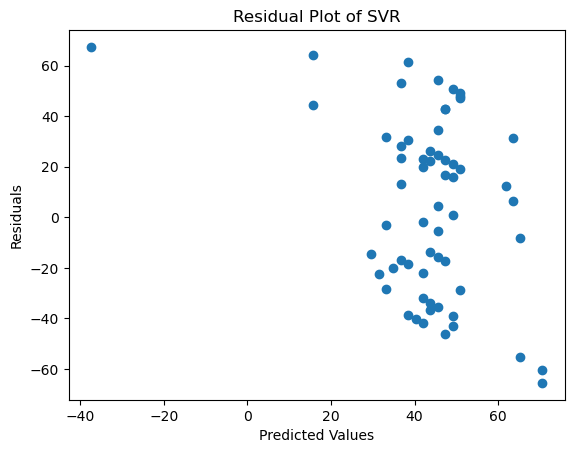

Shapiro-Wilk test for normality of residuals:
Statistic: 0.967003583908081
p-value: 0.09868869930505753
The residuals are likely normally distributed.


In [80]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

# Load the dataset
data = pd.read_csv('new_data_fill_missing_linear&mode.csv')

# data = data.dropna()
# Print the number of missing values in each column
# print(data.isnull().sum())

# Replace missing values with the median value for that column
# data = data.fillna(data.median())

# Separate target variable and feature variables
target = data['stress_level']
data = data.drop(['stress_level','programme',"Tijdstempel",'random_number','good_day_(1)',
                  'good_day_(2)','birthday','bed_time'], axis=1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Scale the features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the hyperparameters to be tuned
param_distributions = {
        'svr__C': [0.1, 1, 10, 100, 1000],
            'svr__epsilon': [0.0001, 0.0005,  0.001, 0.005,  0.01, 0.05, 1, 5, 10],
            'svr__gamma': [0.0001, 0.0005,  0.001, 0.005,  0.01, 0.05, 1, 5, 10],
     'select__k': [2, 3, 4]  # select the best 2, 3, or 4 features
}

# Create a pipeline to select the best features and train the SVR model
pipeline = Pipeline([
    ('select', SelectKBest(f_regression)),
    ('svr', SVR())
])


# Perform a randomized search to find the best hyperparameters
randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_distributions, n_iter=100, cv=5, random_state=42, scoring='neg_mean_absolute_error')
randomized_search.fit(X_train, y_train)

# Print the best hyperparameters and their corresponding MAE score
print("Best hyperparameters:", randomized_search.best_params_)
print("Mean absolute error:", -randomized_search.best_score_)

# Print the selected features and their p-values
selected_features = randomized_search.best_estimator_.named_steps['select'].get_support()
p_values = randomized_search.best_estimator_.named_steps['select'].pvalues_
feature_names = data.columns
for i in range(len(feature_names)):
    print(f"{feature_names[i]}: {selected_features[i]}, p-value: {p_values[i]}")

# Evaluate the performance on the test set using the best hyperparameters
y_pred = randomized_search.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Test set mean absolute error:", mae)
print("Test set R-squared score:", r2)

# Calculate the confidence interval for the test set
n = len(y_test)
k = randomized_search.best_estimator_.named_steps['select'].k
y_mean = np.mean(y_test)
t_value = 1.96 # t-value for 95% confidence interval
y_pred_std = np.sqrt(mae)
ci_half_width = t_value * y_pred_std / np.sqrt(n-k-1)
ci_lower = y_mean - ci_half_width
ci_upper = y_mean + ci_half_width
print(f"95% confidence interval for test set predictions: [{ci_lower}, {ci_upper}]")

# Plot the residuals
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot of SVR")
plt.show()

# Check if the residuals are normally distributed
from scipy.stats import shapiro
stat, p = shapiro(residuals)
print("Shapiro-Wilk test for normality of residuals:")
print("Statistic:", stat)
print("p-value:", p)
if p > 0.05:
    print("The residuals are likely normally distributed.")
else:
    print("The residuals are not normally distributed.")